In [ ]:
!pip install odc-stats==1.0.6a --upgrade

In [ ]:
!pip uninstall ndvi_tools -y

In [ ]:
!pip install ndvi_tools/

In [1]:
import os
import json
import xarray as xr
import geopandas as gpd

import datacube
import matplotlib.pyplot as plt
from deafrica_tools.plotting import display_map
from deafrica_tools.dask import create_local_dask_cluster

from ndvi_tools.ndvi_climatology_plugin import NDVIClimatology

## Test plugin without odc-stats

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:40787 Dashboard: /user/chad_extra/proxy/8787/status,Cluster Workers: 1 Cores: 7 Memory: 63.57 GB


In [3]:
dc = datacube.Datacube(app="Vegetation_anomalies")

In [4]:
lat, lon = -33.0795, 18.8725#34.5117, -5.9119
buffer = 0.05
# Set the range of dates for the climatology
time_range = ('1985', '2020')
resolution = (-30, 30)

lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

In [5]:
display_map(x=lon_range, y=lat_range)

In [6]:
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'resolution': resolution,
    'output_crs':'epsg:6933',
    'measurements':['red','nir','pixel_quality'],
    'group_by':'solar_day'
#     'dask_chunks':dask_chunks
}

### grab data so we can use the geobox parameter to mimic a 'task'

In [7]:
task = dc.load(product=['ls5_sr','ls7_sr','ls8_sr'], dask_chunks={}, **query)

### grab lists of datatsets to mimic .db files

In [8]:
dss = dc.find_datasets(product=['ls5_sr', 'ls7_sr', 'ls8_sr'], **query)

### set up an example config

In [9]:
config = dict(
    resampling="bilinear",
    bands=["red", "nir"],
    mask_band="QA_PIXEL",
    harmonization_slope=0.988,
    harmonization_intercept= -0.015,
    mask_filters=[["opening", 5], ["dilation", 5]],
    flags_ls57=dict(cloud="high_confidence", cloud_shadow="high_confidence"),
    flags_ls8=dict(
        cloud="high_confidence",
        cloud_shadow="high_confidence",
        cirrus="high_confidence",
    ),
)

### Run the plugin code

In [10]:
x=NDVIClimatology(**config)
ndvi = x.input_data(dss, task.geobox)
result = x.reduce(ndvi).compute()
print(result)

CPLReleaseMutex: Error = 1 (Operation not permitted)


<xarray.Dataset>
Dimensions:      (y: 358, x: 322)
Coordinates:
  * y            (y) float64 -3.989e+06 -3.989e+06 -3.99e+06 ... -4e+06 -4e+06
  * x            (x) float64 1.816e+06 1.816e+06 ... 1.826e+06 1.826e+06
    spatial_ref  int32 6933
Data variables: (12/36)
    mean_jan     (y, x) float32 0.1495 0.1526 0.1516 ... 0.1556 0.1573 0.159
    mean_feb     (y, x) float32 0.1475 0.1506 0.1506 ... 0.1455 0.1474 0.149
    mean_mar     (y, x) float32 0.1511 0.1562 0.1561 ... 0.1528 0.1525 0.1538
    mean_apr     (y, x) float32 0.1399 0.144 0.1455 ... 0.159 0.1582 0.1597
    mean_may     (y, x) float32 0.163 0.169 0.1723 0.1745 ... 0.1853 0.1829 0.19
    mean_jun     (y, x) float32 0.4095 0.4279 0.433 ... 0.3611 0.3618 0.3649
    ...           ...
    count_jul    (y, x) float64 25.0 25.0 25.0 24.0 25.0 ... 21.0 21.0 21.0 21.0
    count_aug    (y, x) float64 22.0 22.0 21.0 21.0 21.0 ... 19.0 19.0 17.0 17.0
    count_sep    (y, x) float64 17.0 17.0 16.0 16.0 16.0 ... 17.0 17.0 17.0 17.0
 

### Plot

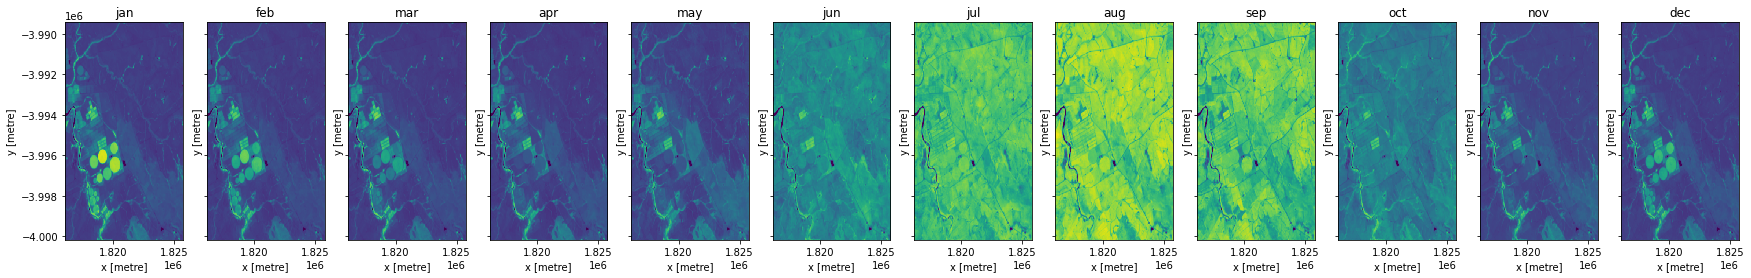

In [26]:
fig,ax=plt.subplots(1,12, sharex=True, sharey=True, figsize=(30,4))
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    result['mean_'+j].plot.imshow(ax=ax[i], add_colorbar=False, vmin=0, vmax=0.9)
    ax[i].set_title(j)

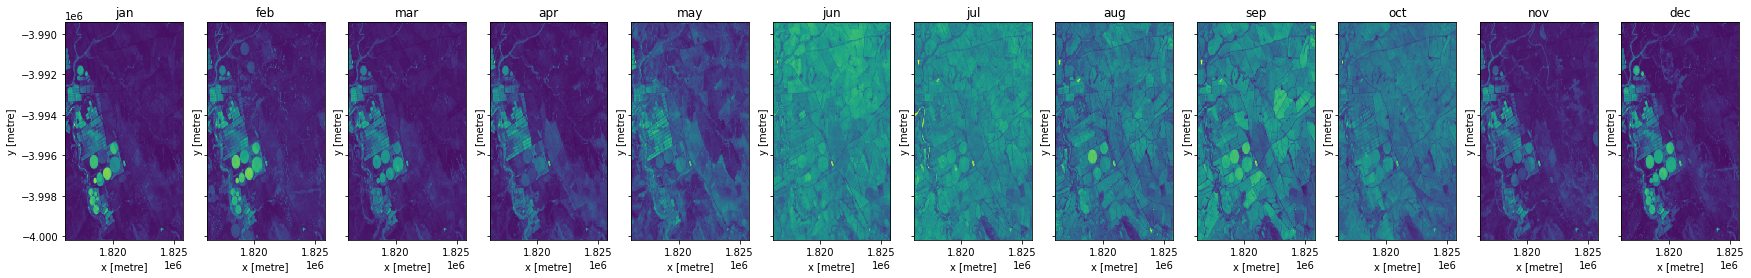

In [32]:
fig,ax=plt.subplots(1,12, sharex=True, sharey=True, figsize=(30,4))
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    result['std_'+j].plot.imshow(ax=ax[i], vmin=0,vmax=0.4, add_colorbar=False)
    ax[i].set_title(j)

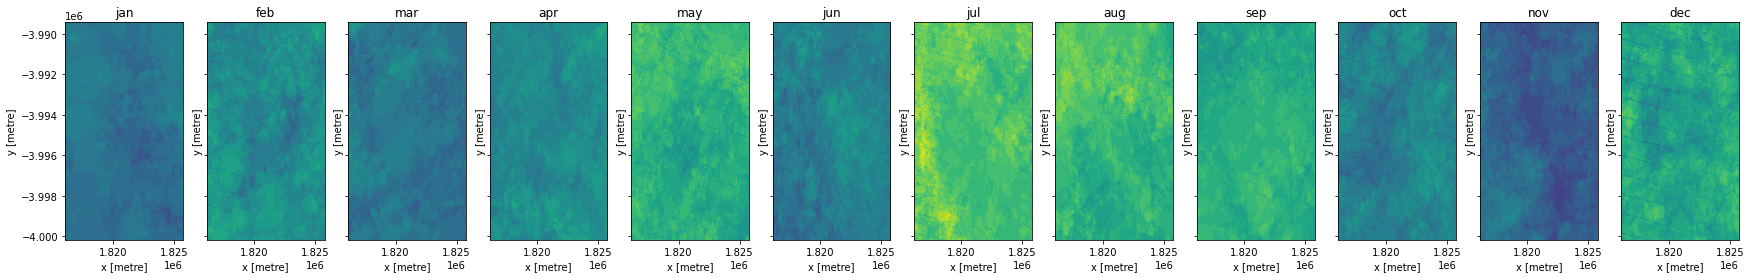

In [31]:
fig,ax=plt.subplots(1,12, sharex=True, sharey=True, figsize=(30,4))
for i,j in zip(range(0,12), ["jan","feb","mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]):
    result['count_'+j].plot.imshow(ax=ax[i], vmin=0, vmax=30, add_colorbar=False)
    ax[i].set_title(j)

## Test plugin with odc-stats

In [ ]:
!pip uninstall ndvi_tools -y

In [ ]:
!pip install ndvi_tools/

In [ ]:
import os
import json
import xarray as xr
import geopandas as gpd
from odc.stats.tasks import TaskReader
from odc.stats.model import OutputProduct

### Generate tasks etc

In [ ]:
!odc-stats save-tasks --frequency annual --grid africa-30 --temporal-range 2011--P4Y ls5_sr-ls7_sr-ls8_sr --frequency all --dataset-filter '{"collection_category": "T1"}'

### Enter the X and Y Tile ID of the tile you want to run

Use the geojson to select a tile id

In [ ]:
tile_x = '174' 
tile_y = '119'  	

t=[int(tile_x), int(tile_y)]

### Extract the tasks object for that tile

In [ ]:
name, version = 'ndvi_climatology', '1-0-0'
op = OutputProduct(
            name='ndvi_climatology',
            version='0-1-0',
            short_name='ndvi_climatology',
            location=f"s3://dummy-bucket/{name}/{version}",
            properties={"odc:file_format": "GeoTIFF"},
            measurements=['red']
        )

taskdb = TaskReader('ls5_sr-ls7_sr-ls8_sr_2011--P4Y.db', product=op)
task = taskdb.load_task(('2010--P6Y', t[0], t[1]))

### Optionally export tile geojson to view

In [ ]:
with open('task_tile_check.geojson', 'w') as fh:
    json.dump(task.geobox.extent.to_crs('epsg:4326').json, fh, indent=2)

### Find the index of the tile we want to run

In [ ]:
tile_index_to_run = []
all_tiles = list(taskdb.all_tiles)
for i, index in zip(all_tiles, range(0, len(all_tiles))):
    if (i[1]==t[0]) & (i[2]==t[1]):
        tile_index_to_run.append(index)
        print(index)

### Try running odc-stats using the config yaml and external plugin

In [ ]:
%%time
os.system("odc-stats run "\
          "ls5_sr-ls7_sr-ls8_sr_2011--P4Y.db "\
          "--config=ndvi_climatology.yaml "\
          "--resolution=60 "\
          "--threads=4 "\
          "--memory-limit=29Gi "\
          "--location=file:///home/jovyan/git/deafrica-sandbox-notebooks/HLS/{product}/{version}/ "+str(tile_index_to_run[0])
         )

In [ ]:
!odc-stats run ls7_sr-ls8_sr_2014--P2Y.db --config=ndvi_climatology.yaml --resolution=80 --threads=4 --memory-limit=29Gi --location=file:///home/jovyan/git/deafrica-sandbox-notebooks/frica-sandbox-notebooks/HLS/{product}/{version} 1202

### Plot results

In [ ]:
mon= 'jul'

In [ ]:
a= 'x'+str(t[0])
b='y'+str(t[1])

mean=xr.open_rasterio('ndvi_climatology/0-0-1/'+a+'/'+b+'/2010--P6Y/ndvi_climatology_'+a+b+'_2010--P6Y_mean_'+mon+'.tif').squeeze()
print(mean)
mean.squeeze().plot.imshow(size=6);

In [ ]:
a= 'x'+str(t[0])
b='y'+str(t[1])

std=xr.open_rasterio('ndvi_climatology/0-0-1/'+a+'/'+b+'/2010--P6Y/ndvi_climatology_'+a+b+'_2010--P6Y_std_'+mon+'.tif').squeeze()
std.squeeze().plot.imshow(size=6);

In [ ]:
a= 'x'+str(t[0])
b='y'+str(t[1])

count=xr.open_rasterio('ndvi_climatology/0-0-1/'+a+'/'+b+'/2010--P6Y/ndvi_climatology_'+a+b+'_2010--P6Y_count_'+mon+'.tif').squeeze()
count.squeeze().plot.imshow(size=6);

### remove results folder

In [ ]:
!rm -r -f ndvi_climatology/